First, we load up some useful libraries for visualization and data structures.

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.axes as axes
import copy
import random

Next we need a Maze class for pathfinding. It will help to have read the RedBlobGames [A\* tutorial](http://www.redblobgames.com/pathfinding/a-star/introduction.html) before continuing.

These Mazes are defined in ASCII diagrams and can have walls ("#"), empty spaces ("."), switches (numbers), and doors (letters; closed are uppercase). The "0" switch toggles the open status of all the "a" doors, "1" goes to the "b" doors, etc. Mazes can also contain pits: "?" pits have a 30% chance of killing the player and "!" pits have a 60% chance. Every maze has one player start location "@" and one goal square "X". Walls and closed doors block movement.

[(1, 0), (0, -1), (0, 1), 'switch']


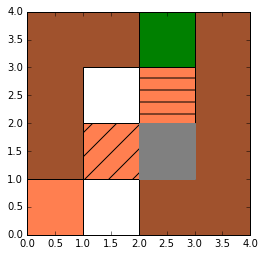

In [3]:
class Maze:
    SwitchMap = {"0":"a", "1":"b", "2":"c", "3":"d", "4":"e", "5":"f", "6":"g", "7":"h", "8":"i", "9":"j"}
    Colors = {"a":"coral","b":"tan","c":"palegreen","d":"blue","e":"cyan","f":"magenta","g":"yellow","h":"olive","i":"purple","j":"darkgreen",
              "0":"coral","1":"tan","2":"palegreen","3":"blue","4":"cyan","5":"magenta","6":"yellow","7":"olive","8":"purple","9":"darkgreen",
             "?":"orange",
             "!":"red",
             "x":"green","@":"gray",
             "#":"sienna",".":"white"}
    
    def __init__(self,rows):
        self.grid = [list(r) for r in rows]
        self.grid.reverse()
        height = len(self.grid)
        width = len(self.grid[0])
        self.exit_pos = None
        self.player_pos = None
        self.player_alive = True
        for y in range(0,height):
            assert len(self.grid[y]) == width, "All rows must be equal length!"
            for x in range(0,width):
                c = self.grid[y][x]
                assert c == "#" or c == "." or c == "!" or c == "?" or c == "@" or c.isalnum()
                if c.lower() == "x":
                    assert self.exit_pos == None
                    self.exit_pos = (x,y)
                if c == "@":
                    assert self.player_pos == None
                    self.player_pos = (x,y)
                    self.grid[y][x] = "."
    
    def clone(self):
        return copy.deepcopy(self)
    
    def toggle_cell(self,switchnum,c):
        if c.isalpha() and Maze.SwitchMap[switchnum] == c.lower():
            if c.islower():
                return c.upper()
            else:
                return c.lower()
        return c
    
    def toggle(self):
        assert self.player_alive
        height = len(self.grid)
        width = len(self.grid[0])
        (px,py) = self.player_pos
        switchnum = self.grid[py][px]
        assert switchnum.isnumeric()
        for y in range(0,height):
            for x in range(0,width):
                self.grid[y][x] = self.toggle_cell(switchnum,self.grid[y][x])
    
    def is_free(self,x,y):
        if y < 0 or y >= len(self.grid):
            return False
        if x < 0 or x >= len(self.grid[0]):
            return False
        cell = self.grid[y][x]
        return (
            cell == "." or cell == "x" or cell == "X" or
            cell == "?" or cell == "!" or 
            (cell.isalpha() and cell.islower()) or cell.isnumeric() or self.exit_pos==(x,y)
        )
    
    def move_player(self,dx,dy):
        assert self.player_alive
        assert abs(dx)+abs(dy) == 1
        (x,y) = self.player_pos
        (newx,newy) = (x+dx,y+dy)
        assert self.is_free(newx,newy)
        self.player_pos = (x+dx,y+dy)
        cell = self.grid[y+dy][x+dx]
        if cell == "?" and random.random() < 0.3:
            self.player_alive = False
        if cell == "!" and random.random() < 0.6:
            self.player_alive = False
    
    def available_moves(self):
        if not self.player_alive:
            return []
        (x,y) = self.player_pos
        can_switch = self.grid[y][x].isnumeric()
        return [(dx,dy) for (dx,dy) in [(-1,0),(1,0),(0,-1),(0,1)] if self.is_free(x+dx,y+dy)] + (
            ["switch"] if can_switch else []
        )
    
    def is_at_exit(self):
        return self.player_alive and self.player_pos == self.exit_pos
    
    def draw(self):
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(1,1,1, aspect='equal')
        ax1.set_axis_bgcolor('sienna')
        height = len(self.grid)
        width = len(self.grid[0])
        ax1.set_xlim([0,width])
        ax1.set_ylim([0,height])
        for y in range(0,height):
            for x in range(0,width):
                cell = self.grid[y][x]
                if cell == "#": continue
                is_door = cell.isalpha() and cell.lower() != "x"
                is_pit = cell == "?" or cell == "!"
                is_open = is_door and cell.islower()
                is_switch = cell.isnumeric()
                ax1.add_patch(
                    patches.Rectangle((x, y),
                                      1,1,
                                      fill=True,
                                      facecolor=Maze.Colors[cell.lower()],
                                      edgecolor="black",
                                      hatch="/" if is_switch else ("-" if (is_door and not is_open) else None),
                                      label=cell)
                )
        ax1.add_patch(
            patches.Rectangle(self.player_pos,
                              1,1,
                              fill=True,
                              hatch="x" if not self.player_alive else None,
                              facecolor=Maze.Colors["@"] if self.player_alive else "black",
                              edgecolor=Maze.Colors["@"] if self.player_alive else "white")
        )
        plt.show(fig1)
    
    def __eq__(self,other):
        return self.grid == other.grid and self.player_pos == other.player_pos and self.player_alive == other.player_alive
    
    def __neq__(self,other):
        return not self == other
    
    def __hash__(self):
        return hash(str(self.grid)) % 1000007 + hash(self.player_pos) % 1000007 + hash(self.player_alive) % 1000007
    
    def __cmp__(self,other):
        if self == other:
            return 0
        return __cmp__(id(self), id(other))
    
    
sample=Maze([
        "##x#",
        "#.A#",
        "#0?#",
        "a@##"
    ])
sample.move_player(0,1)
print(sample.available_moves())
sample.move_player(1,0)
sample.draw()

# Assignment 1

Write a function to solve pathfinding and switch-and-door puzzles with one of the heuristic search algorithms described during the lecture. Try it on the provided sample puzzles; if a puzzle gives your algorithm trouble, try to explain why that happens. Make sure the path you're getting is the actual shortest path!

Try to get this assignment done by Friday; the other two may take a little longer but the sooner you attempt them the earlier you can get feedback!

You may also try visualizing paths through the maze, implementing several different heuristic searches, comparing against aheuristic search, etc.

Generating mazes automatically would also be a great exercise!

In [3]:
import queue
pri = queue.PriorityQueue()
tileMap=[]
vh_cost=10
class Tile:
    heuristicCost=0
    finalCost=0
    x=0
    y=0
    hv_cost=10
    parent= None
    null =False
    def __init__(self,x,y,null):
        self.x=x
        self.y=y
        self.null=null
def heuristic(maze):
    grid=maze.grid
    width=len(grid[0])
    height=len(grid)
    tileMap=[[Tile(0,0,True)] *height]*width
    blockedMap=[]
    
    print(height)
    print(width)
    closed=[[False] *height]*width
    not_solved=True
    for j in range (0,len(grid)):
        for k in range (0,len(grid[0])):
            if(grid[j][k]=="#"):
                blockedMap = blockedMap +[(k,j)]
    for i in range (0,width):
        for j in range (0,height):
            tileMap[i][j] = Tile(i, j, False)
            tileMap[i][j].heuristicCost = abs(i - maze.player_pos[0])+ abs(j - maze.player_pos[1])
    for i in range (0,len(blockedMap)):
        tileMap[blockedMap[i][0]][blockedMap[i][1]]=None
    while(not_solved):
        #print(str(maze.grid))
        points =a_star(maze.player_pos[0],maze.player_pos[1],maze.exit_pos[0],maze.exit_pos[1],tileMap,closed)
        not_solved=False
    # Return a path which solves the maze: a sequence of elements like (dx,dy) or "switch".
    # You can use maze.exit_pos and query maze.grid[row][column] to investigate the maze.
    return points
count = 0
def update_value(current, t, tileValue,pri,closed):
        global count
        count+=1
        if (t==None or closed[t.x][t.y]):
            print("Not working")
            return
        t_final_cost = t.heuristicCost + tileValue
        inOpen = t in pri.queue
        if (not inOpen or t_final_cost < t.finalCost):
            t.finalCost = t_final_cost
            t.parent = current
            if (not inOpen):
                pri.put((t_final_cost,count, t))

def a_star(starty,startx,endx,endy,tileMap,closed):
    pri.put((1,0, Tile(startx,starty,False)))
    while True:
        if (pri.empty()):#Also try if (pri.empty()):
            break
        current =pri.get()[2]
       
        print(len(tileMap))
        print(len(tileMap[0]))
        print("X:"+str(current.x))
        print("Y:"+str(current.y))
        closed[current.x][current.y] = True
        if (current.x==endx and current.y==endy):
            return;
        if (current.x-1>=0):
            t = tileMap[current.x - 1][current.y]
            update_value(current, t, current.finalCost + vh_cost,pri,closed)
        if (current.y - 1 >= 0):
            t = tileMap[current.x][current.y - 1]
            update_value(current, t, current.finalCost + vh_cost,pri,closed)

        if (current.y + 1 < len(tileMap[0])):
            t = tileMap[current.x][current.y + 1]
            update_value(current, t, current.finalCost + vh_cost,pri,closed)
        if (current.x + 1 < len(tileMap)):
            t = tileMap[current.x + 1][current.y]
            update_value(current, t, current.finalCost + vh_cost,pri,closed)
    points=[]
    if (closed[endx][endy]):
        current = tileMap[endx][endy]
        points= [(current.x, current.y)]
        while (not current.parent == None):
            points=points+ [(current.parent.x, current.parent.y)]
            current = current.parent
    return points

#Change blocked closed to use is_free might fix glich 1
#Glitch 2 fix unknown

In [4]:
#Example
import queue

prio_queue = queue.PriorityQueue()
prio_queue.put((2, 8, 'super blah'))
prio_queue.put((1, 4, 'Some thing'))
prio_queue.put((1, 3, 'This thing would come after Some Thing if we sorted by this text entry'))
prio_queue.put((5, 1, 'blah'))

while not prio_queue.empty():
    item = prio_queue.get()
    print('%s.%s - %s' % item)

1.3 - This thing would come after Some Thing if we sorted by this text entry
1.4 - Some thing
2.8 - super blah
5.1 - blah


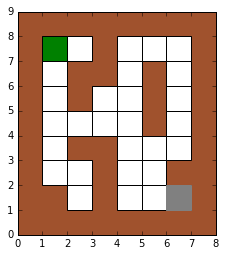

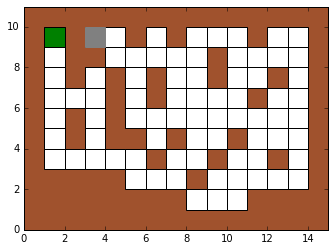

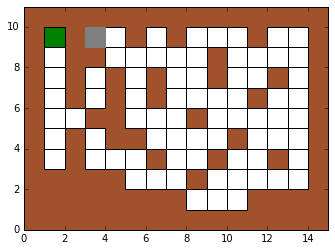

In [4]:
def maze1():
    return Maze([
        "########",
        "#X.#...#",
        "#.##.#.#",
        "#.#..#.#",
        "#....#.#",
        "#.##...#",
        "#..#..##",
        "##.#..@#",
        "########"
    ])

maze1().draw()

def maze2():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#...#.#....#..#",
        "#.#.#.........#",
        "#.#.##.#..#...#",
        "#.....#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

maze2().draw()

def mazeUnsolvable1():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#.#.#.#....#..#",
        "#..##...#.....#",
        "#.#.##....#...#",
        "#.#...#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

mazeUnsolvable1().draw()

In [ ]:
print(heuristic(maze1()))
print("done")
print(heuristic(maze2()))

You also have to be able to handle switch and door puzzles:

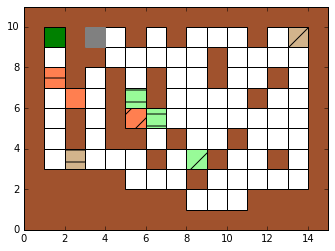

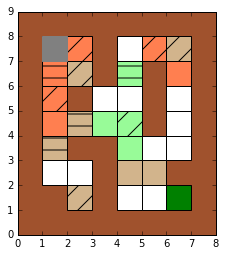

In [5]:
def maze3():
    return Maze([
        "###############",
        "#X#@.#.#...#.1#",
        "#.##.....#....#",
        "#A#.#.#..#..#.#",
        "#.a.#C#....#..#",
        "#.#.#0C.......#",
        "#.#.##.#..#...#",
        "#.B...#.2#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

maze3().draw()

def maze4():
    return Maze([
        "########",
        "#@0#.01#",
        "#A1#C#a#",
        "#0#..#.#",
        "#aBc2#.#",
        "#B##c..#",
        "#..#bb##",
        "##1#..X#",
        "########"
    ])

maze4().draw()

In [ ]:
print(heuristic(maze3()))
print(heuristic(maze4()))

# Assignment 2

Once you have this working, write an agent which finds a policy for a "blind" puzzle using MCTS. "Blind" puzzles are just like the puzzles above, only (a) you don't get to see the whole puzzle or know the goal states in advance, and (b) some nodes are trap doors with a chance of dropping the player into a bottomless pit! Try different policies for deciding between exploit/explore and for doing rollouts and compare them.  Plot graphs on how learning improves with  more rollouts.

Of course, it should also be able to solve the earlier maze puzzles!

In [13]:
from random import randint
import sys
import math


class Node:
    trials=1
    successes=0
    depth=0
    parent= None
    children=[]
    action=(0,0)
    playerxy=(0,0)
    value=0
    SwitchMap={}
    def __init__(self,depth,parent,action,playerxy,SwitchMap):
        self.depth=depth
        self.parent=parent
        self.action=action
        self.playerxy=playerxy
        self.SwitchMap=SwitchMap

def back_propo_suc(node,value):
        node.successes+=value
        if(not node.parent==None):
            back_propo_suc(node.parent,value)

def foward_propo(node,depth,prop_suc,prop_tri):
    for child in current.children:
        if(child.depth==depth):
            propo_suc+=child.successes
            prop_tri+=child.successes
        else:
            tup=foward_propo_suc(child,depth,prop_suc,prop_tri)
            prop_suc+=tup[0]
            prop_tri+=tup[1]
        return (prop_suc,prop_tri)
            
def back_propo_tri(node):
        node.trials+=1
        if(not node.parent==None):
            back_propo_tri(node.parent)
            
def back_check(current,node):
    if(not current.parent==None):
        if(current.parent.playerxy==node.playerxy and current.parent.SwitchMap==node.SwitchMap):
            return current.parent
        else:
            node = back_check(current.parent,node)
    return node
    
        

def mcts(maze,iterations):
    hundred_group=[]
    moves=[]
    root = Node(0,None,(0,0),maze.player_pos,maze.SwitchMap)
    total_wins=0
    print(str(len(maze.grid)*len(maze.grid[0])))
    for i in range (0,iterations):
        current=root
        moves=[]
        maze_copy=maze.clone()
        last_move=()
        while (maze_copy.player_alive):
            back_propo_tri(current)
            if(current.depth>1000):
                back_propo_suc(current,-10)
                break
            loto=-1
            not_done_yet_moves=[]
            #print("Break:")
            test=[]#Test not nessisary
            for child in range (0,len(current.children)-1):
                if(not i==0):
                    current.children[child].value= (current.children[child].successes/current.children[child].trials)+(2**(1/2)/4)*((math.log(i)/current.children[child].trials)**(1/2))# This might need to be ajusted
                else:
                    current.children[child].value=1
                    loto+=current.children[child].value
                #print(str(current.children[child].trials))
                #print("Loto: "+str(current.children[child].value))
                #print("Depth: "+str(current.children[child].depth)+" Loto: "+str(current.children[child].value))
                test=test+[current.children[child].action]
            for move in range (0,len(maze_copy.available_moves())):
                not_there=True
                for child in range (0,len(current.children)-1):
                    if (current.children[child].action==move):
                        not_there=False
                if not_there:
                    not_done_yet_moves=not_done_yet_moves+[maze_copy.available_moves()[move]]
                    loto+=1
                    #print("Loto: "+"1")
            #if (not test==[]):
                #print(str(test))
            random_int = randint(0, int(loto))
            
            #if (not len(moves)-1==-1):
            #    if (moves[len(moves)-1]==maze_copy.available_moves()[random_int]):
            #        random_int=-1
            if(not random_int ==-1):
                move=(0,0)
                count=0
                if (random_int<len(not_done_yet_moves)):
                    move = maze_copy.available_moves()[int(random_int)]
                else:
                    count+=len(not_done_yet_moves)
                    for child in range (0,len(current.children)-1):
                        if(not len(current.children)-1==-1):
                            if (count==random_int or count<random_int and random_int<count+current.children[child].value):
                                move=current.children[child].action
                        count+=current.children[child].value
                    #print(current.children[child].value)
                #print("Count:"+str(count)+"\nLoto:"+str(loto))
                moves= moves + [move]
                #print(move)
                maze_copy.move_player(move[0],move[1])
                create_new=True
                for child in current.children:
                        if (child.action==move):
                            create_new=False
                            current=child
                if(create_new):
                    new_current=Node(current.depth+1,current,move,maze_copy.player_pos,maze_copy.SwitchMap)
                    current.children= current.children+[new_current]
                    current=new_current
                check=back_check(current,current)
                if(not check==current):
                    current=check
                    
                #Toggle for draw
                if (i+1==iterations):
                    maze_copy.draw()
                if(maze_copy.player_alive and maze_copy.player_pos == maze_copy.exit_pos):
                    back_propo_suc(current,len(maze.grid)*len(maze.grid[0])*69444.444444/(current.depth**2))#May need to be ajusted
                    total_wins+=100/(8**current.depth)
                    #print("Depth: "+str(current.depth)+" Win: "+str(10000/(current.depth**2)))
                    break
                if(not maze_copy.player_alive):
                    current.successes=-1
        print("#"+str(i+1)+" : "+str(len(moves))+"\n")
        hundred_group=hundred_group+[len(moves)]
        if(len(hundred_group)==100):
            print("Hundred Group:"+str(sum(hundred_group)/len(hundred_group)))
            hundred_group=[]
    return (moves, 0)

sys.setrecursionlimit(2000)
print ("Path:" + str(mcts(maze1(),20000)))
#TODO Maze,survey,project idea

72
#1 : 151

#2 : 53

#3 : 361

#4 : 193

#5 : 451

#6 : 401

#7 : 887

#8 : 159

#9 : 733

#10 : 313

#11 : 233

#12 : 37

#13 : 217

#14 : 223

#15 : 159

#16 : 295

#17 : 209

#18 : 73

#19 : 363

#20 : 493

#21 : 609

#22 : 253

#23 : 153

#24 : 141

#25 : 193

#26 : 551

#27 : 251

#28 : 269

#29 : 219

#30 : 367

#31 : 69

#32 : 541

#33 : 127

#34 : 213

#35 : 33

#36 : 747

#37 : 91

#38 : 893

#39 : 525

#40 : 223

#41 : 117

#42 : 117

#43 : 371

#44 : 321

#45 : 443

#46 : 149

#47 : 55

#48 : 887

#49 : 223

#50 : 125

#51 : 851

#52 : 157

#53 : 477

#54 : 147

#55 : 71

#56 : 199

#57 : 411

#58 : 65

#59 : 259

#60 : 407

#61 : 877

#62 : 117

#63 : 139

#64 : 259

#65 : 365

#66 : 121

#67 : 253

#68 : 233

#69 : 113

#70 : 165

#71 : 1549

#72 : 211

#73 : 955

#74 : 27

#75 : 33

#76 : 113

#77 : 1545

#78 : 301

#79 : 89

#80 : 673

#81 : 69

#82 : 221

#83 : 441

#84 : 1285

#85 : 39

#86 : 835

#87 : 179

#88 : 245

#89 : 151

#90 : 507

#91 : 261

#92 : 411

#93 :

KeyboardInterrupt: 

In [45]:
sucesses = 1
trials = 1
depth=11
value= 1 + sucesses/(2**depth)/(1.2**1)/trials*10000000000*1000
value=1+ **(1/2)
print(value)

4069010417.666667


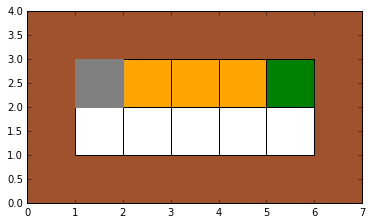

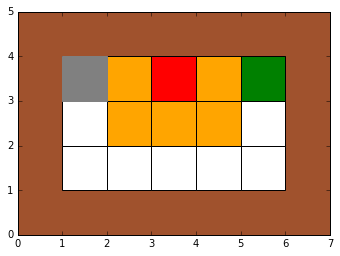

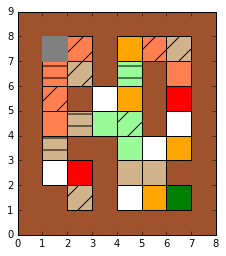

In [6]:
def maze5():
    return Maze([
        "#######",
        "#@???X#",
        "#.....#",
        "#######"
    ])

maze5().draw()

def maze6():
    return Maze([
        "#######",
        "#@?!?X#",
        "#.???.#",
        "#.....#",
        "#######"
    ])

maze6().draw()

def maze7():
    return Maze([
        "########",
        "#@0#?01#",
        "#A1#C#a#",
        "#0#.?#!#",
        "#aBc2#.#",
        "#B##c.?#",
        "#.!#bb##",
        "##1#.?X#",
        "########"
    ])

maze7().draw()

# Assignment 3

Do assignment 2 again, but with reinforcement learning! Compare various approaches and parameters (e.g.\ different discounting rates, Sarsa vs Q-learning, etc) against your MCTS agents in terms of iterations required to reach certain levels of performance. Plot graphs showing how learning improves with more iterations. Print or draw out (at least some of) the state-value or action-value matrix.

Read as much as you care to of Sutton & Barto---[section 2](https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node39.html) is especially useful.


In [ ]:
def rl(maze,iterations):
    # Return the best path (most likely to lead to success) along with its expected value and a validated value
    # for a budget of `iterations` experiments.
    # As above, don't look at maze.exit_pos or maze.grid:
    # you're only allowed to query `maze.available_moves()`, `maze.player_alive`, and `maze.is_at_exit`.

    # After training for `iterations` experiments, run an agent through the maze using that learned policy 
    # for a large number of times and return the average reward:
    # (best_path, expected_reward, test_reward)

    return ([],0,0)